In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import shutil
#import splitfolders
from PIL import Image
import torch
# import yaml
# from IPython.display import Image, clear_output
# from utils.plots import plot_results

c:\Users\Tobias\anaconda3\envs\dv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters and Constants


In [24]:
TRAIN = True
# Number of epochs to train for.
EPOCHS = 15

directory = "datasets/exDark"
#output = "datasets/exDark/img_all"
yolov5sDir = "runs/train/exDark_model_yolov5s_15epochs"

In [24]:
import os 

cwd = os.getcwd()
print(cwd)

C:\Ablage\Master\DeepVision\Studienarbeit\YOLOv5-vs-RCNN


## Download and Prepare the Dataset

In [ ]:
!git clone "https://github.com/ultralytics/yolov5.git"
%cd yolov5
%pip install -qr requirements.txt 

In [5]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)
    else: 
        print('File already present, skipping download...')

In [3]:
if not os.path.exists('../exDark'):
    # !unzip -q "traffic-vehicles-object-detection.zip"
    print('Download Dataset')
else:
    print('Dataset already present')

Download Dataset


In [6]:
def rearangeDir(directory, output):
    for root, subdirectories, files in os.walk(directory):
        for file in files:
            print(os.path.join(root, file))
            shutil.move(os.path.join(root, file), output)

In [7]:
#moves files from subdirectories into images/labels directory
def moveFiles(directory, old_dir):

    if not os.path.exists(directory + "/images"):
        os.mkdir(directory + "/images")
    if not os.path.exists(directory + "/labels"):
        os.mkdir(directory + "/labels")

    for filename in os.listdir(old_dir):
        source = os.path.join(old_dir, filename)
        if filename.endswith(".txt"):
            destination = os.path.join(directory + "/labels", filename)
            shutil.copyfile(source, destination)
        else:
            destination = os.path.join(directory + "/images", filename)
            shutil.copyfile(source, destination)


In [8]:
#only for .txt files
def removeExtraChars(path, specialChar):
    for file in os.listdir(path):
        newname = file.split(specialChar, 1)[0] + ".txt"
        os.rename(os.path.join(path,file),os.path.join(path,newname))

Converts exDark Labels to yolov5 Labels

In [9]:
#Bicycle 204 28 271 193 0 0 0 0 0 0 0
#0 0.408 0.07466666666666667 0.542 0.5146666666666667

import imagesize

class_names = [
    "Bicycle", "Boat", "Bottle", "Bus", "Car", "Cat", "Chair", "Cup", "Dog", "Motorbike", "People", "Table"
] 

def removeNullsAndConvert(path_txt, path_img, labels):
    for image in os.listdir(path_img):
        
        file, fileEnding = image.split(".")
        file = file + ".txt"

        fin = open(path_txt + "/" + file, 'r')
        img_w, img_h = imagesize.get(os.path.join(path_img, image))
        label_lines = fin.readlines()
        
        for j, label_line in enumerate(label_lines, start=0):
            bbox_string = label_line[0:]
            label, x_c, y_c, w, h, rest = bbox_string.split(' ', maxsplit=5)

            for index, l in enumerate(labels, start=0):
                if label == l:
                    newLabel = index

            img_w = int(img_w)
            img_h = int(img_h)
            x_center = float(int(x_c)/img_w)
            y_center = float(int(y_c)/img_h)
            width = float(int(w)/img_w)
            height = float(int(h)/img_h)

            label_lines[j] = str(newLabel) + " " + str(x_center + width/2) + " " + str(y_center + height/2) + " " + str(width) + " " + str(height) + "\n"

        fout = open(os.path.join(path_txt, file), 'w')
        fout.writelines(label_lines)
        fout.close()


In [11]:
def removeFirstLine():
    path = "../datasets/exDark/labels/"
    for file in os.listdir(path):
        with open(path + file, 'r') as fin:
            data = fin.read().splitlines(True)
        with open(path + file, 'w') as fout:
            fout.writelines(data[1:])

In [9]:
# def splitfolders_(input_dir, output_dir):
#     splitfolders.ratio(input_dir, output=output_dir,
#         seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False)
# splitfolders_("../datasets/exDark", "../datasets/exDark")

In [12]:
def resize(path, dirs):
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((416,416), Image.ANTIALIAS)
            imResize.save(f + e, quality=90)
            print("sucess")
        else:
            print("fail")

In [ ]:
#moveFiles(directory, output)
#removeExtraChars("../{directory}/labels", ".")
#removeFirstLine()

# removeNullsAndConvert("{directory}/test/labels", "{directory}/test/images", class_names)
# removeNullsAndConvert("{directory}/train/labels", "{directory}/train/images", class_names)
# removeNullsAndConvert("{directory}/val/labels", "{directory}/val/images", class_names)

### Visualize a Few Ground Truth Images

Before moving forward, let's check out few of the ground truth images. 

The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format. Here is a function that converts it to `[x_min, y_min, x_max, y_max]` format.

In [13]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=4
        ) 
        cv2.putText(
            image, 
            class_names[int(labels[box_num])],
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2
        )
    return image

# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples, random):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    plt.figure(figsize=(21, 12))
    for i in range(num_samples):
        image = cv2.imread(all_training_images[i+random])
        with open(all_training_labels[i+random], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                # label = label_line[0]
                bbox_string = label_line[0:]
                label, x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.show()

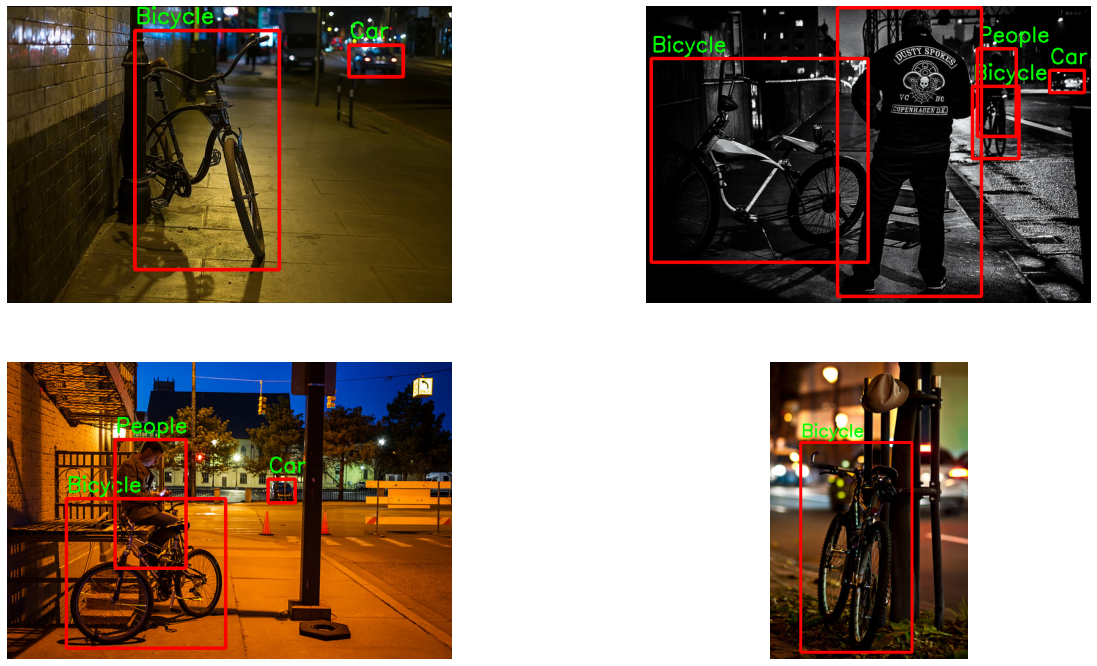

In [15]:
# Visualize a few training images.
# need to be in yolov5 directory
plot(
    image_paths='datasets/exDark/train/images/*', 
    label_paths='datasets/exDark/train/labels/*',
    num_samples=4,
    random=41
)

## Helper Functions for Logging

**Function to Monitor TensorBoard logs**.

In [18]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir yolov5/runs/train

## Training using YOLOV5

In [19]:
monitor_tensorboard()

In [20]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.11.0+cu113 _CudaDeviceProperties(name='NVIDIA GeForce GTX 1080 Ti', major=6, minor=1, total_memory=11263MB, multi_processor_count=28)


In [22]:
#%cd yolov5

c:\Ablage\Master\DeepVision\Studienarbeit\YOLOv5-vs-RCNN\yolov5


In [23]:
if TRAIN:
    !python train.py --data exDark.yaml --cfg yolov5s.yaml --epochs 15 --batch-size 40 --name exDark_model_yolov5s_15epochs

wandb: Currently logged in as: vanschott. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=exDark.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=15, batch_size=40, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=exDark_model_yolov5s_15epochs, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
From https://github.com/ultralytics/yolov5
   a80dd66..47233e1  master          -> origin/master
   b2c7124..394be0c  ultralytics/HUB -> origin/ultralytics/HUB
github:  YOLOv5 is out of date by 2 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
requirements

## Results

In [10]:
from IPython.display import HTML, display

display(HTML('<h1>Left Bounding Boxes from Label File || Right Bounding Boxes from yolov5s_15epochs</h1>'))
display(HTML("<table><tr><td><img src='output_images/yolov5s_exDark/val_batch2_labels.jpg'></td><td><img src='output_images/yolov5s_exDark/val_batch2_pred.jpg'></td></tr></table>"))

,


`results.png` für visDrone_Model_yolov5s mit 15 epochen
> <img src='output_images/yolov5s_exDark/results.png' width="900">  

In [36]:
!python val.py --weights {yolov5sDir}/weights/best.pt --data exDark.yaml --half

val: data=C:\Ablage\Master\DeepVision\Studienarbeit\YOLOv5-vs-RCNN\yolov5\data\exDark.yaml, weights=['runs/train/exDark_model_yolov5s_15epochs/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5  v6.1-244-g47233e1 Python-3.9.12 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs

val: Scanning 'C:\Ablage\Master\DeepVision\Studienarbeit\YOLOv5-vs-RCNN\datasets\exDark\val\labels.cache' images and labels... 1472 found, 0 missing, 1 empty, 0 corrupt: 100%|██████████| 1472/1472 [00:00<?, ?it/s]
val: Scanning 'C:\Ablage\Master\DeepVision\Studienarbeit\YOLOv5-vs-RCNN\datasets\exDark\val\labels.cache' images and labels... 1472 found, 0 missing, 1 em

In [31]:
!python val.py --weights {yolov5sDir}/weights/best.pt --data exDark.yaml --half --task test

val: data=C:\Ablage\Master\DeepVision\Studienarbeit\YOLOv5-vs-RCNN\yolov5\data\exDark.yaml, weights=['runs/train/exDark_model_yolov5s_15epochs/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5  v6.1-244-g47233e1 Python-3.9.12 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs

test: Scanning 'C:\Ablage\Master\DeepVision\Studienarbeit\YOLOv5-vs-RCNN\datasets\exDark\test\labels' images and labels...:   0%|          | 0/737 [00:00<?, ?it/s]
test: Scanning 'C:\Ablage\Master\DeepVision\Studienarbeit\YOLOv5-vs-RCNN\datasets\exDark\test\labels' images and labels...1 found, 0 missing, 0 empty, 0 corrupt:   0%|          | 1/737 [00:02<36:24,  2.9

In [6]:
display(HTML('<h1>Left Bounding Boxes from Label File || Right Bounding Boxes from yolov5s_15epochs</h1>'))
display(HTML("<table><tr><td><img src='output_images/yolov5s_exDark/val_batch2_labels2.jpg'></td><td><img src='output_images/yolov5s_exDark/val_batch2_pred2.jpg'></td></tr></table>"))

,


In [7]:
display(HTML("<table><tr><td><img src='output_images/yolov5s_exDark/val_batch1_labels.jpg'></td><td><img src='output_images/yolov5s_exDark/val_batch1_pred.jpg'></td></tr></table>"))

,


### Training Medium Model

In [ ]:
if TRAIN:
    #!python train.py --data exDark.yaml --cfg yolov5m.yaml --epochs 15 --batch-size 24 --name exDark_model_yolov5m_15epochs

In [8]:
display(HTML('<h1>Left: exDark_Model_yolov5m_15epochs 40 batch size  || Right: exDark_Model_yolov5m_15epochs 24 batch size</h1>'))
display(HTML("<table><tr><td><img src='output_images/yolov5s_exDark/results.png'></td><td><img src='output_images/yolov5m_exDark/results.png'></td></tr></table>"))

,


![test](attachement:val_batch2_labels2.jpg)

In [16]:
display(HTML('<h1>Left Bounding Boxes from Label File || Right Bounding Boxes from yolov5s_15epochs</h1>'))
display(HTML("<table><tr><td><img src='val_batch2_labels2.jpg'></td><td><img src='val_batch2_pred2.jpg'></td></tr></table>"))

,
